In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
"""
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.preprocessing import image

from keras.models import Model
from keras import layers
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.engine.topology import get_source_inputs
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions



TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'


def Xception(include_top=True, weights='imagenet',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
        
"""
"""
    Instantiates the Xception architecture.
    Optionally loads weights pre-trained
    on ImageNet. This model is available for TensorFlow only,
    and can only be used with inputs following the TensorFlow
    data format `(width, height, channels)`.
    You should set `image_data_format="channels_last"` in your Keras config
    located at ~/.keras/keras.json.
    Note that the default input image size for this model is 299x299.
    # Arguments
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization)
            or "imagenet" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(299, 299, 3)`.
            It should have exactly 3 inputs channels,
            and width and height should be no smaller than 71.
            E.g. `(150, 150, 3)` would be one valid value.
        pooling: Optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    # Returns
        A Keras model instance.
    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
"""
"""
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')

    if K.backend() != 'tensorflow':
        raise RuntimeError('The Xception model is only available with '
                           'the TensorFlow backend.')
    if K.image_data_format() != 'channels_last':
        warnings.warn('The Xception model is only available for the '
                      'input data format "channels_last" '
                      '(width, height, channels). '
                      'However your settings specify the default '
                      'data format "channels_first" (channels, width, height). '
                      'You should set `image_data_format="channels_last"` in your Keras '
                      'config located at ~/.keras/keras.json. '
                      'The model being returned right now will expect inputs '
                      'to follow the "channels_last" data format.')
        K.set_image_data_format('channels_last')
        old_data_format = 'channels_first'
    else:
        old_data_format = None

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=299,
                                      min_size=71,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)

    if include_top:
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='xception')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('xception_weights_tf_dim_ordering_tf_kernels.h5',
                                    TF_WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('xception_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    TF_WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)

    if old_data_format:
        K.set_image_data_format(old_data_format)
    return model
"""
print("skip")

skip


In [3]:
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras.layers import Dense, Input, BatchNormalization, Activation
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
#from keras.applications.imagenet_utils import _obtain_input_shape
from keras.utils.data_utils import get_file

from keras.datasets import mnist
from PIL import Image
# for creating a one hot vector for labels
from keras.utils import np_utils
from IPython.display import display, Image
#import the models
from keras import Model
#add layers
from keras import layers
#add optimizer
from keras import optimizers
#add loss function 
from keras import losses

import keras
import numpy as np
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
 

Source : https://github.com/yanchummar/xception-keras/blob/master/xception_model.py

In [4]:
def Xception():

	# Determine proper input shape
	input_shape = (128,128,3)
  # _obtain_input_shape(None, default_size=299, min_size=71, data_format='channels_last', include_top=False)

	img_input = Input(shape=input_shape)

	# Block 1
	x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False)(img_input)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = Conv2D(64, (3, 3), use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 2
	x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 2 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	residual = Conv2D(256, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 3
	x = Activation('relu')(x)
	x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 3 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	residual = Conv2D(728, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 4
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	# Block 5 - 12
	for i in range(8):
		residual = x

		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)
		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)
		x = Activation('relu')(x)
		x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
		x = BatchNormalization()(x)

		x = layers.add([x, residual])

	residual = Conv2D(1024, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
	residual = BatchNormalization()(residual)

	# Block 13
	x = Activation('relu')(x)
	x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)

	# Block 13 Pool
	x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
	x = layers.add([x, residual])

	# Block 14
	x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	# Block 14 part 2
	x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False)(x)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	# Fully Connected Layer
	x = GlobalAveragePooling2D()(x)
	x = Dense(1000, activation='softmax')(x)

	inputs = img_input

	# Create model
	model = Model(inputs, x, name='xception')

	# Download and cache the Xception weights file
	#weights_path = get_file('xception_weights.h5', WEIGHTS_PATH, cache_subdir='models')

	# load weights
	#model.load_weights(weights_path)

	return model

In [5]:
model = Xception()
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["acc"],
)
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [6]:
print("Hello world.")

Hello world.


108
0
100
108   108
skip


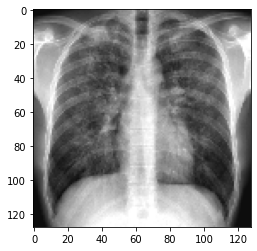

In [7]:
x = []
label = []
valid_covid = "/content/drive/MyDrive/datasets/3_December_dataSet_1_step/validation/COVID19"
valid_covid_list = os.listdir(valid_covid)

print(len(valid_covid_list))
for i in range( 0, len(valid_covid_list)):
    if i % 100 == 0:
       print(i)
    link = valid_covid+'/'+ valid_covid_list[i]
    img = cv2.imread(link)
    image = cv2.resize(img, ( 128 , 128 ))
    x.append(image)
    #print(gray_image)
    label.append([0])

plt.imshow(image)
print(len(x)," ", len(label))
print("skip")

110
0
100
218   218
skip


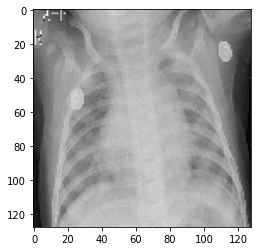

In [8]:

valid_pneumonia = "/content/drive/MyDrive/datasets/3_December_dataSet_1_step/validation/PNEUMONIA"
valid_pneumonia_list = os.listdir(valid_pneumonia)

print(len(valid_pneumonia_list))
for i in range( 0, len(valid_pneumonia_list)):
    if i % 100 == 0:
       print(i)
    link = valid_pneumonia+'/'+ valid_pneumonia_list[i]
    img = cv2.imread(link)
    image = cv2.resize(img, ( 128 , 128 ))
    x.append(image)
    #print(gray_image)
    label.append([1])

plt.imshow(image)
print(len(x)," ", len(label))
print("skip")

110
0
100
328   328
skip


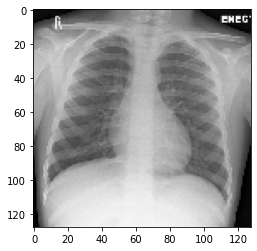

In [9]:

valid_normal = "/content/drive/MyDrive/datasets/3_December_dataSet_1_step/validation/NORMAL"
valid_normal_list = os.listdir(valid_normal)

print(len(valid_normal_list))
for i in range( 0, len(valid_normal_list)):
    if i % 100 == 0:
       print(i)
    link = valid_normal+'/'+ valid_normal_list[i]
    img = cv2.imread(link)
    image = cv2.resize(img, ( 128 , 128 ))
    x.append(image)
    #print(gray_image)
    label.append([2])

plt.imshow(image)
print(len(x)," ", len(label))
print("skip")

In [10]:
x = np.asarray(x)
print(x)


[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[144 144 144]
   [138 138 138]
   [144 144 144]
   ...
   [ 35  35  35]
   [ 28  28  28]
   [ 24  24  24]]

  [[145 145 145]
   [148 148 148]
   [144 144 144]
   ...
   [ 33  33  33]
   [ 19  19  19]
   [ 12  12  12]]

  [[158 158 158]
   [158 158 158]
   [160 160 160]
   ...
   [ 27  27  27]
   [ 19  19  19]
   [  9   9   9]]]


 [[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [ 55  55  55]
   [ 21  21  21]
   [ 13  13  13]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [ 90  90  90]
   [255 255 255]
   [  7   7   7]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  1   1   1]
   [ 15  15  15]
   [  0   0

In [11]:
label = np.array(label)
label = keras.utils.to_categorical(label, 1000 )
print(label)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [12]:
model.fit(x, label ,  epochs=100, validation_split=0.2)

Epoch 1/100
9/9 [==============================] - 94s 9s/step - loss: 3.9245 - acc: 0.2597 - val_loss: 6.7996 - val_acc: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 83s 9s/step - loss: 1.3959 - acc: 0.5715 - val_loss: 6.7321 - val_acc: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 84s 9s/step - loss: 1.1609 - acc: 0.5812 - val_loss: 6.6323 - val_acc: 0.0000e+00
Epoch 4/100
9/9 [==============================] - 83s 9s/step - loss: 0.7442 - acc: 0.7035 - val_loss: 6.5963 - val_acc: 0.0000e+00
Epoch 5/100
9/9 [==============================] - 84s 9s/step - loss: 0.7400 - acc: 0.6838 - val_loss: 6.4962 - val_acc: 0.0000e+00
Epoch 6/100
9/9 [==============================] - 83s 9s/step - loss: 0.5924 - acc: 0.7904 - val_loss: 6.3304 - val_acc: 1.0000
Epoch 7/100
9/9 [==============================] - 84s 9s/step - loss: 0.5905 - acc: 0.8156 - val_loss: 6.2952 - val_acc: 0.0000e+00
Epoch 8/100
9/9 [==============================] - 98s 11s/step - loss: 0

In [13]:
p = "/content/drive/MyDrive/datasets/3_December_dataSet_1_step/validation/COVID19"

test_data = []
p_covid = os.listdir(p)
#print(p_cats)
for i in range (0, len(p_covid)):
   link = p+'/'+p_covid[i]
   img = cv2.imread(link)
   img = cv2.resize(img, ( 128 ,  128 ))
#plt.imshow(img)
   test_data.append(img)


test_data_covid = np.array(test_data)
#test = test / 255.0
prediction_covid =  model.predict(test_data_covid)


In [14]:
array = []
print(len(prediction_covid))
for i in range(0, len(prediction_covid)):
   #print(len(prediction_covid[i]))
   array.append(prediction_covid[i][0])
   array.append(prediction_covid[i][1])
   array.append(prediction_covid[i][2])
   maximum = max(array)
   #print("length of array ", len(array))
   id = array.index(maximum)
   if id != 0:
      print("error in index ",id)
   array.clear()
   #print("length of array ",len(array))

108


In [15]:
p = "/content/drive/MyDrive/datasets/3_December_dataSet_1_step/validation/PNEUMONIA"

test_data = []
p_pneumonia = os.listdir(p)
#print(p_cats)
for i in range (0, len(p_pneumonia)):
   link = p+'/'+p_pneumonia[i]
   img = cv2.imread(link)
   img = cv2.resize(img, ( 128 ,  128 ))
#plt.imshow(img)
   test_data.append(img)


test_data_pneumonia = np.array(test_data)
#test = test / 255.0
prediction_pneumonia =  model.predict(test_data_pneumonia)

array = []
print(len(prediction_pneumonia))
for i in range(0, len(prediction_pneumonia)):
   #print(len(prediction_covid[i]))
   array.append(prediction_pneumonia[i][0])
   array.append(prediction_pneumonia[i][1])
   array.append(prediction_pneumonia[i][2])
   maximum = max(array)
   id = array.index(maximum)
   if id != 1:
      print(id)
   array.clear()

110


In [16]:
p = "/content/drive/MyDrive/datasets/3_December_dataSet_1_step/validation/NORMAL"

test_data = []
p_normal = os.listdir(p)
#print(p_cats)
for i in range (0, len(p_normal)):
   link = p+'/'+p_normal[i]
   img = cv2.imread(link)
   img = cv2.resize(img, ( 128 ,  128 ))
#plt.imshow(img)
   test_data.append(img)


test_data_normal = np.array(test_data)
#test = test / 255.0
prediction_normal =  model.predict(test_data_normal)

array = []
print(len(prediction_normal))
for i in range(0, len(prediction_normal)):
   #print(len(prediction_covid[i]))
   array.append(prediction_normal[i][0])
   array.append(prediction_normal[i][1])
   array.append(prediction_normal[i][2])
   maximum = max(array)
   id = array.index(maximum)
   if id != 2:
      print(id)
   array.clear()

110
1
1
1
1
1
0
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
0
1
0
1
0
1
1
1
1
0
